In [6]:
!pip install bertopic
!pip install sentence-transformers
!pip install openpyxl
!pip install umap-learn
!pip install hdbscan
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import re
from collections import Counter
import nltk

# For stopwords and lemmatization
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\samru\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Load your Excel file, e.g. 'meToo_with_topics.xlsx'
df = pd.read_excel("tweets_with_topics(result).xlsx")  
# Check columns
print(df.columns)
print(df.head())

In [29]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-letter characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Split into tokens
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Rejoin
    return ' '.join(tokens)
df['text_cleaned'] = df['tweet'].astype(str).apply(clean_text)

In [33]:
def remove_high_occurrence_keywords(df, threshold=0.2):
    """
    Identify and remove keywords whose occurrence ratio is above `threshold`.
    Occurrence ratio = (Number of tweets containing the keyword) / (Total tweets).

    Additionally, print all keywords with their frequencies and occurrence ratios.
    """
    # Count how many tweets we have
    total_tweets = len(df)

    # Count how many tweets each keyword occurs in
    tweet_freq = Counter()
    for text in df['text_cleaned']:
        tokens = set(text.split())
        tweet_freq.update(tokens)

    # Print all keywords with their frequencies and occurrence ratios
    print("Keyword | Frequency | Occurrence Ratio")
    for token, count in tweet_freq.most_common():
        ratio = count / total_tweets
        print(f"{token} | {count} | {ratio:.4f}")
    
    # Determine which tokens exceed the threshold
    high_freq_tokens = []
    for token, count in tweet_freq.items():
        ratio = count / total_tweets
        if ratio > threshold:
            high_freq_tokens.append(token)

    # Print out the high occurrence tokens to be removed
    if high_freq_tokens:
        print("\nHigh occurrence keywords (ratio > {}):".format(threshold))
        for token in high_freq_tokens:
            ratio = tweet_freq[token] / total_tweets
            print(f"{token} -> Frequency: {tweet_freq[token]}, Occurrence ratio: {ratio:.4f}")
    else:
        print("\nNo high occurrence keywords exceed the threshold.")

    # Function to remove these tokens from a single tweet
    def filter_tokens(text):
        tokens = text.split()
        tokens = [t for t in tokens if t not in high_freq_tokens]
        return ' '.join(tokens)

    # Apply filtering and create a new column with the cleaned text
    df['text_no_event'] = df['text_cleaned'].apply(filter_tokens)
    
    return df
df = remove_high_occurrence_keywords(df, threshold=0.2)

Keyword | Frequency | Occurrence Ratio
metoo | 473 | 0.9753
women | 110 | 0.2268
movement | 72 | 0.1485
sexual | 68 | 0.1402
amp | 52 | 0.1072
men | 44 | 0.0907
one | 36 | 0.0742
harassment | 34 | 0.0701
like | 33 | 0.0680
people | 33 | 0.0680
timesup | 29 | 0.0598
woman | 29 | 0.0598
metoopublicity | 27 | 0.0557
abuse | 27 | 0.0557
us | 27 | 0.0557
see | 27 | 0.0557
man | 26 | 0.0536
would | 26 | 0.0536
metooindia | 24 | 0.0495
get | 24 | 0.0495
need | 22 | 0.0454
media | 22 | 0.0454
story | 21 | 0.0433
allegations | 20 | 0.0412
dont | 20 | 0.0412
u | 20 | 0.0412
stories | 19 | 0.0392
also | 19 | 0.0392
believe | 19 | 0.0392
must | 19 | 0.0392
way | 19 | 0.0392
come | 18 | 0.0371
time | 18 | 0.0371
even | 17 | 0.0351
support | 17 | 0.0351
girls | 17 | 0.0351
talk | 16 | 0.0330
back | 16 | 0.0330
please | 16 | 0.0330
assault | 15 | 0.0309
take | 15 | 0.0309
first | 15 | 0.0309
rape | 15 | 0.0309
want | 15 | 0.0309
violence | 15 | 0.0309
victim | 14 | 0.0289
know | 14 | 0.0289
change | 

In [19]:
synonym_map = {
    'metoo': ['me_too', 'meto', '#metoo'],
    'woman': ['women'],
    'man': ['men'],
    'harass': ['harassment', 'harassed', 'harassing'],
    'sex': ['sexual', 'sexually'],
    'support': ['supporting', 'supports', 'supported'],
    'movement': ['campaign', 'cause'],
    'abuse': ['abused', 'abuser', 'abusive'],
    'assault': ['assaulted', 'assaulting'],
    'report': ['reported', 'reporting'],
}


lemmatizer = WordNetLemmatizer()

def unify_variants(text):
    tokens = text.split()
    unified_tokens = []
    for token in tokens:
        replaced = False
        # Check synonym map
        for canonical, variants in synonym_map.items():
            if token in variants or token == canonical:
                unified_tokens.append(canonical)
                replaced = True
                break
        # If not in the synonym map, lemmatize
        if not replaced:
            lemma = lemmatizer.lemmatize(token)
            unified_tokens.append(lemma)
    return ' '.join(unified_tokens)

In [21]:
# Step 1: Clean text and remove standard stopwords
df['text_cleaned'] = df['tweet'].astype(str).apply(clean_text)

# Step 2: Remove event representative keywords
# Example threshold = 0.75 (75%)
# df = remove_high_occurrence_keywords(df, threshold=0.2)

# Step 3: Unify morphological variants & synonyms (lemmatization + custom map)
df['text_preprocessed'] = df['text_no_event'].apply(unify_variants)

# Inspect changes
print("\nFinal preprocessed text:")
print(df[['tweet', 'text_cleaned', 'text_no_event', 'text_preprocessed']].head(10))


Final preprocessed text:
                                               tweet  \
0  Also - the jokes. The jokes. \u2018If I now sh...   
1  #MeToo #MeTooIndia #MeTooControversy #MeToo4Pu...   
2  ONLY 40 charges and thousands of cries for hel...   
3  Former cricketer and Cricket Association of Be...   
4  My dream is that one day everyone will know wh...   
5  Still,better than my neighbour or'Stalker' as ...   
6  Louis CK now stands also as #MeToo short-form....   
7  If you excuse your boy\u2019s behavior you cre...   
8  Since my #metoo moment:  * Someone tried to un...   
9  Sharman Joshi Opens Up On #MeToo: \"Maligning ...   

                                        text_cleaned  \
0  also jokes jokes uif shake hands yell metoou f...   
1  metoo metooindia metoocontroversy metoopublici...   
2  charges thousands cries help many victim uberr...   
3  former cricketer cricket association bengal ca...   
4  dream one day everyone know words metoo signif...   
5  stillbetter neighb


Refined topic distribution:
topic_refined
-1     119
 0      47
 1      44
 2      39
 3      33
 4      30
 5      25
 6      24
 7      22
 8      16
 9      16
 10     15
 11     12
 12     12
 13     11
 14     10
 15     10
Name: count, dtype: int64


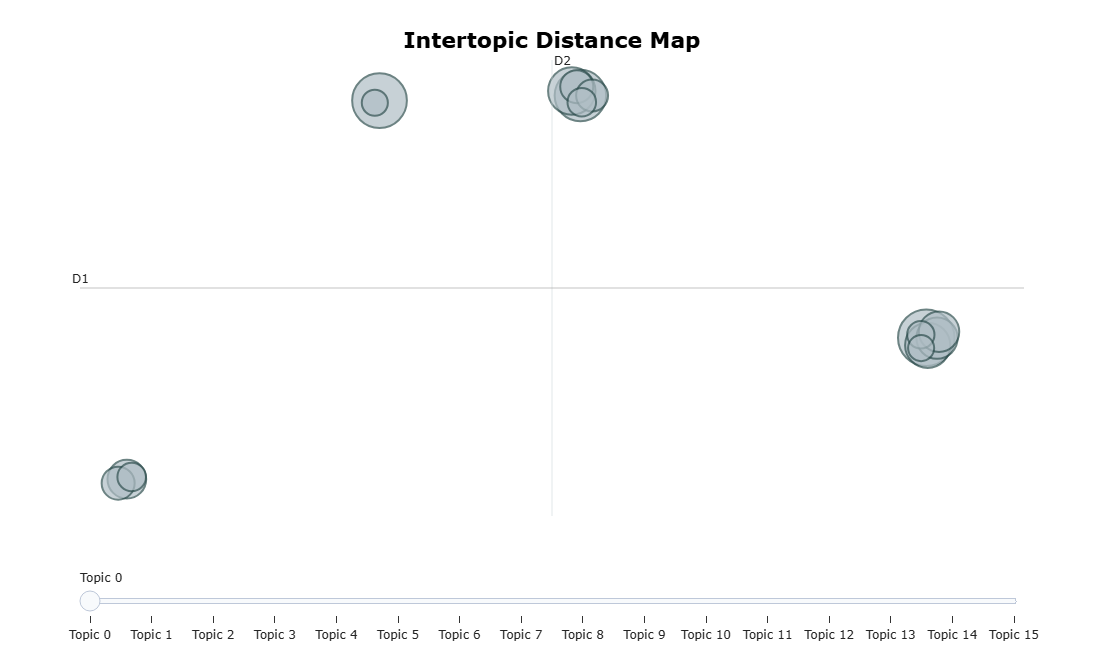

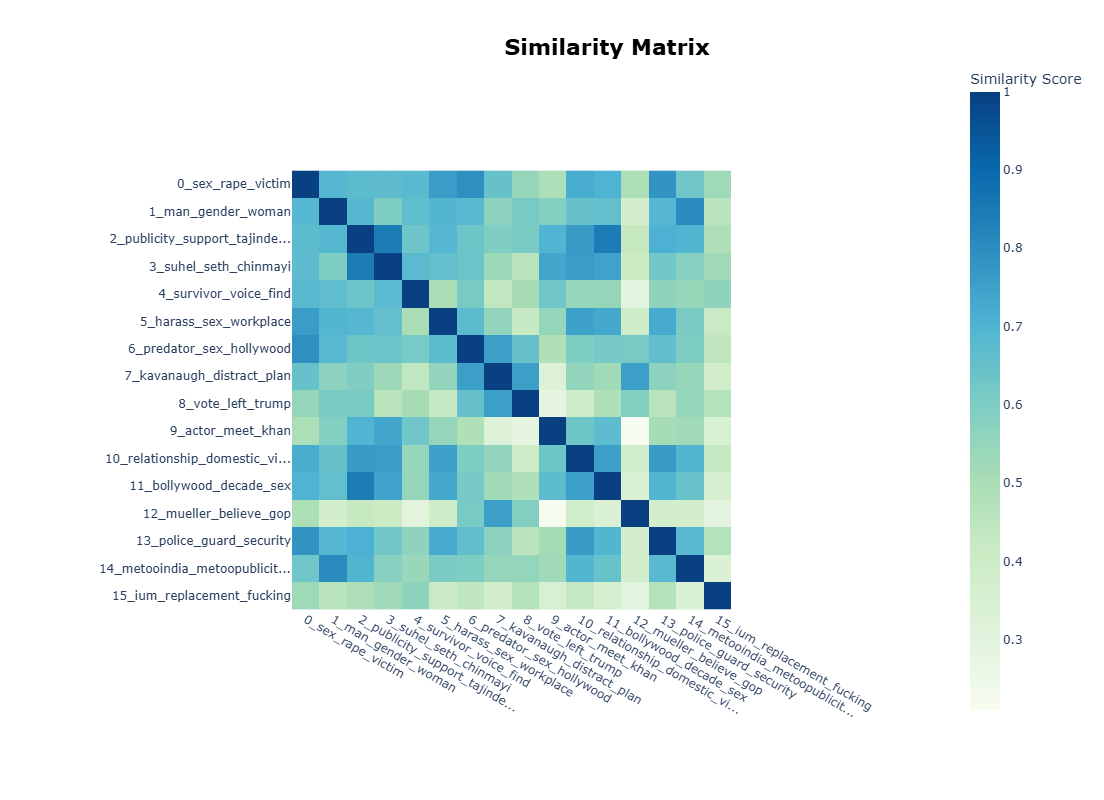

In [45]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

# 1) Build the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2) Tune UMAP for better local structure
umap_model = umap.UMAP(
    n_neighbors=15,        # consider more neighbors for smoother manifold
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# 3) Tune HDBSCAN to allow smaller clusters (fewer outliers)
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,   # allow clusters as small as 10 documents
    min_samples=1,        # be permissive: fewer points considered noise
    metric='euclidean',
    cluster_selection_method='eom'
)

# 4) Initialize BERTopic with custom UMAP & HDBSCAN
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
)

# 5) Fit & transform on your final preprocessed text
docs = df['text_preprocessed'].tolist()
topics, probs = topic_model.fit_transform(docs)

# 6) Save the new topic assignments
df['topic_refined'] = topics

# 7) Inspect how many tweets ended up in each topic (including -1)
print("\nRefined topic distribution:")
print(df['topic_refined'].value_counts())

# 8) Visualize the Intertopic Distance Map
intertopic_distance_map = topic_model.visualize_topics()
intertopic_distance_map.show()

# 9) Visualize the Topic Similarity Heatmap
similarity_heatmap = topic_model.visualize_heatmap()
similarity_heatmap.show()

# 10) (Optional) Save your results
df.to_excel("MeToo_pre-processed_refined_topics(result).xlsx", index=False)


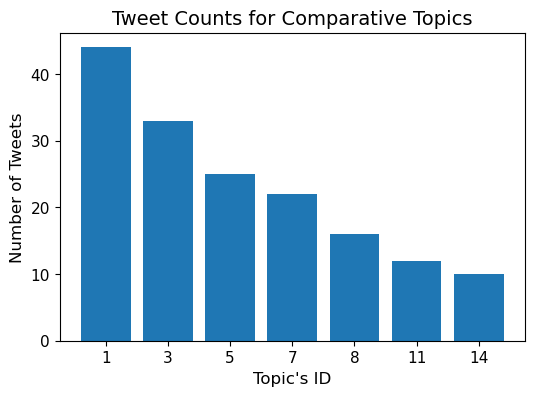

In [47]:
import matplotlib.pyplot as plt

# 1) Select the topic IDs you want to plot
selected_topics = [1, 3, 5, 7, 8, 11, 14]


# 2) Compute the counts for those topics (fills 0 if missing)
counts = df['topic_refined'].value_counts().reindex(selected_topics, fill_value=0)

# 3) Sort by count descending
counts = counts.sort_values(ascending=False)

# 4) Plot
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Topic's ID", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Tweet Counts for Comparative Topics", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()